---
# Stochastic Simulation Assignment 3
---

### **Contributors**  
- **Maarten Stork**  
- **Paul Jungnickel**  
- **Lucas Keijzer**

### **Overview**  
This notebook contains the code and analysis for **Assignment 3 of Stochastic Simulation**. The code follows the order specified in the assignment guidelines and replicates the experiments conducted in the referenced paper. Each section corresponds to (a) key experiment(s).

In [1]:
from CircleParticleSim import *
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import numpy as np
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt

---

# 1) Optimal Particle Configuration

The following code block generates visual representations of the optimal configurations for \(n = 11, 12,\) and \(50\). These visualizations depict the best possible outcomes and have been included in the report.

Running experiment for n=11...
Completed simulation for 11 particles (averaged over 50 runs).
Running experiment for n=12...
Completed simulation for 12 particles (averaged over 50 runs).
Running experiment for n=50...
Completed simulation for 50 particles (averaged over 50 runs).


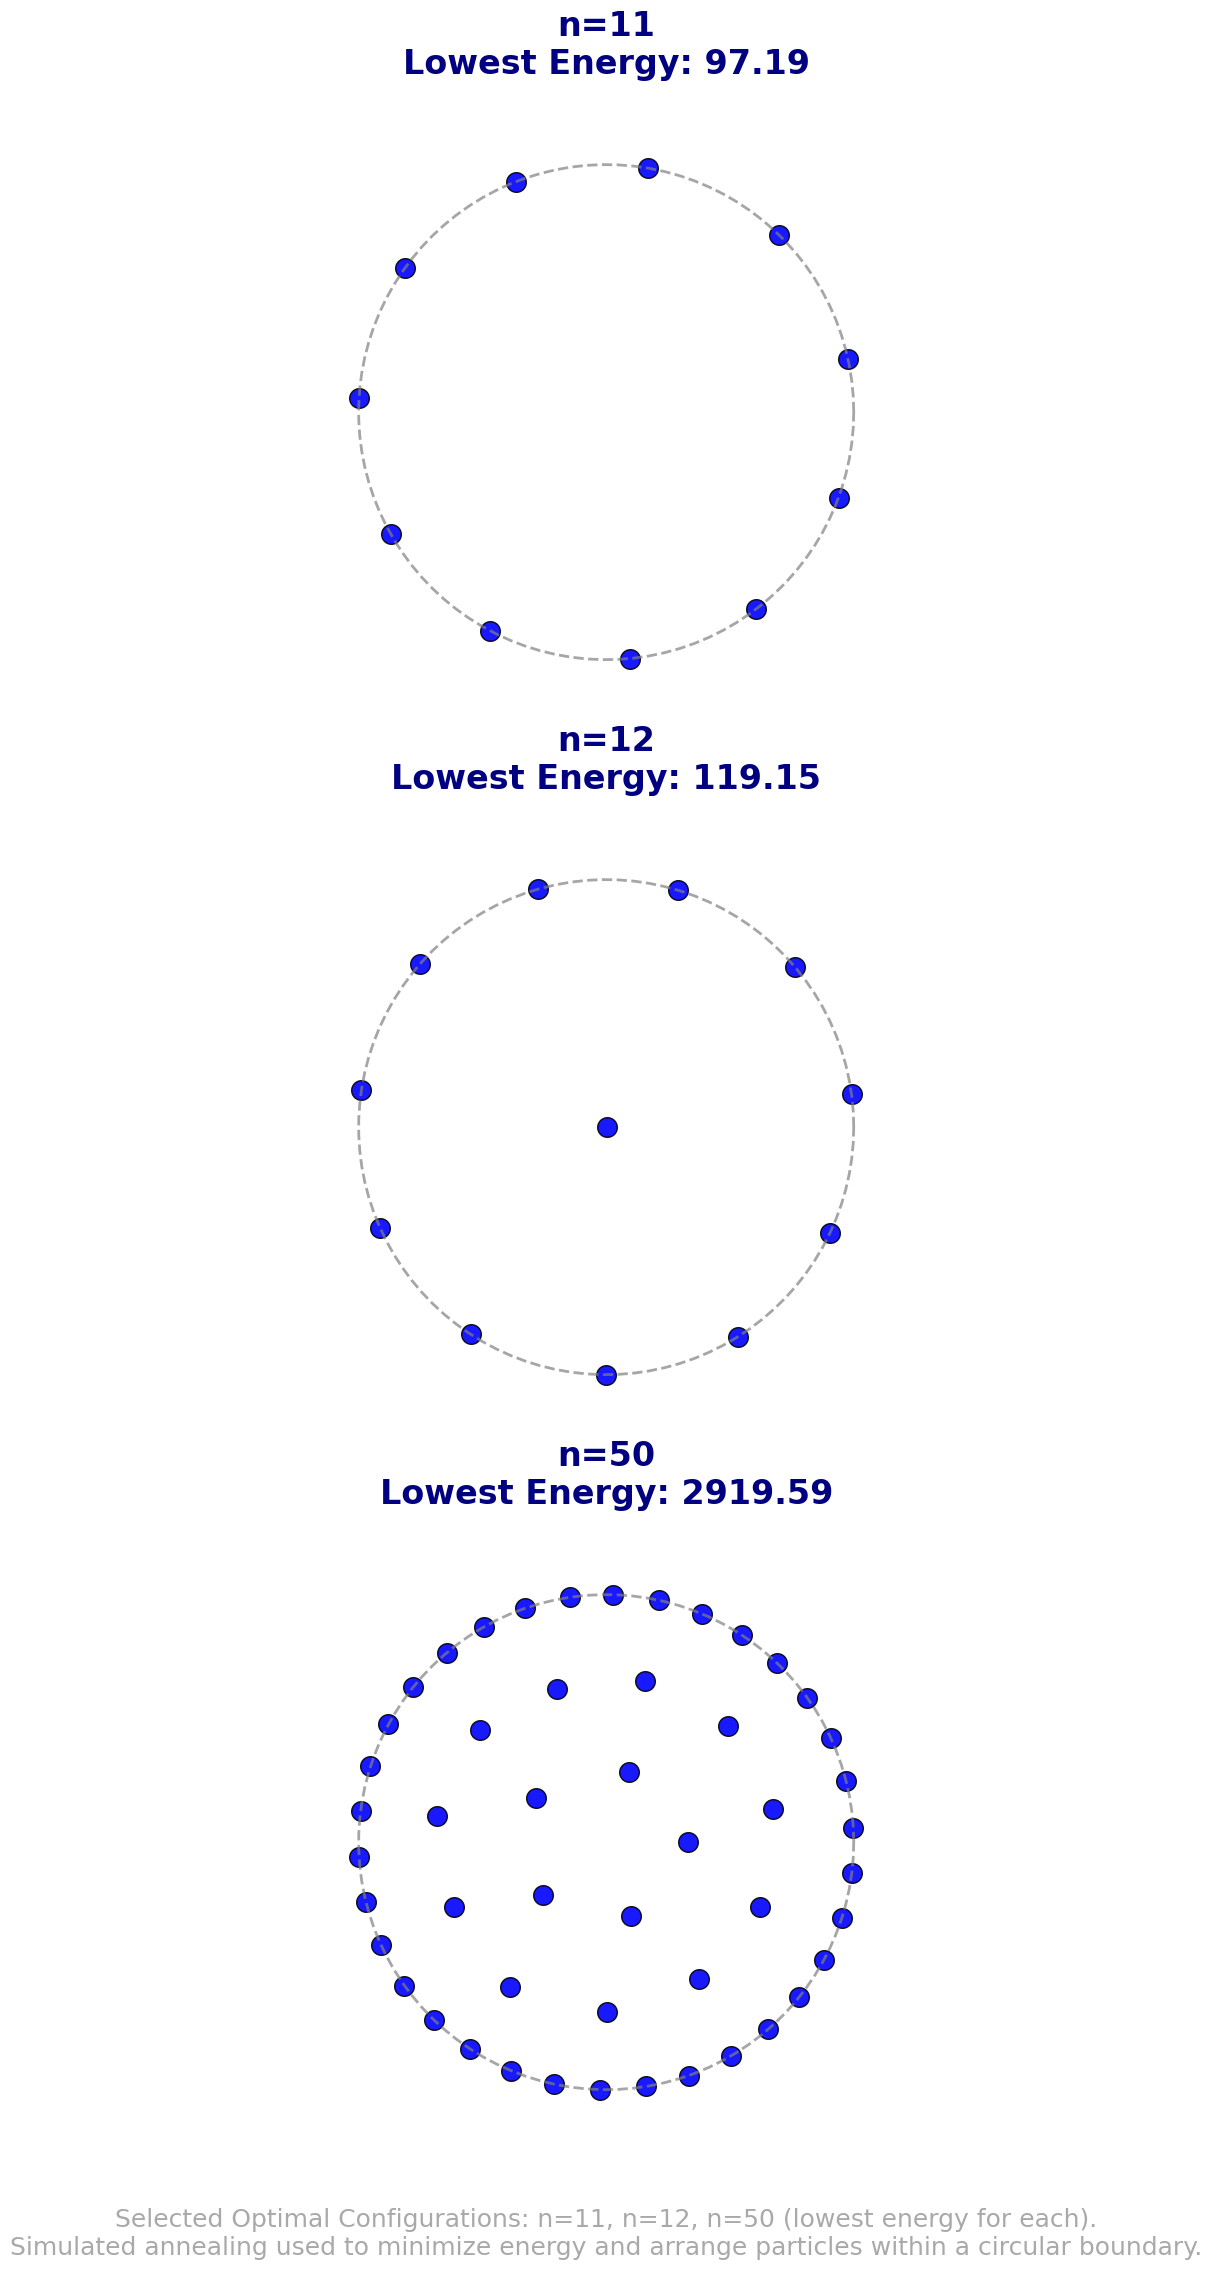

In [32]:
def run_experiment(steps, num_particles, num_runs=10):
    """
    Run the simulation for a given number of particles and store configurations and energies.
    """
    internal_counts = []
    energies = []
    raw_data = []
    energy_examples = {"locations": [], "energies": []}

    for run in range(num_runs):
        sim = CircleParticleSim(
            N=num_particles,
            cooling_schedule=paper_cooling_schedule,
            step_size_schedule=sqrt_step_size_schedule,
            steps=steps
        )
        sim.run_simulation(steps)

        # Calculate floating particles (not on the edge)d
        floating_count = np.sum(np.linalg.norm(sim.particle_locations, axis=1) < 0.99)
        internal_counts.append(floating_count)
        energies.append(sim.E)

        # Store raw data
        raw_data.append({
            "Run": run,
            "Floating Count": floating_count,
            "Energy": sim.E
        })

        # Save configurations and energies
        energy_examples["locations"].append(sim.particle_locations)
        energy_examples["energies"].append(sim.E)

    avg_internal_count = np.mean(internal_counts)
    min_internal_count = np.min(internal_counts)
    max_internal_count = np.max(internal_counts)

    results = {
        "Particles": num_particles,
        "Internal Count (Avg)": avg_internal_count,
        "Internal Count (Min)": min_internal_count,
        "Internal Count (Max)": max_internal_count,
        "Total Energy (Avg)": np.mean(energies)
    }

    print(f"Completed simulation for {num_particles} particles (averaged over {num_runs} runs).")

    return results, raw_data, energy_examples

def plot_selected_configurations(selected_examples):
    """
    Plot configurations for n=11, n=12, and n=50, each showing the lowest energy configuration.
    """
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 24))  # Adjust layout for vertical alignment
    particle_counts = [11, 12, 50]

    for i, (ax, n_particles) in enumerate(zip(axes, particle_counts)):
        locations = selected_examples[n_particles]["locations"]
        energies = selected_examples[n_particles]["energies"]

        # Find the best configuration (lowest energy)
        best_index = np.argmin(energies)
        best_configuration = locations[best_index]
        best_energy = energies[best_index]

        # Plot the configuration
        thetas = np.linspace(0, 2 * np.pi, 100)
        ax.plot(np.cos(thetas), np.sin(thetas), linestyle='--', color='gray', linewidth=2, alpha=0.7)
        ax.scatter(
            best_configuration[:, 0], best_configuration[:, 1],
            color='blue', edgecolor='black', s=200, alpha=0.9
        )

        # Set the title
        ax.set_title(
            f"n={n_particles}\nLowest Energy: {best_energy:.2f}",
            fontsize=24, fontweight='bold', color='navy', pad=30
        )

        # Styling
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])
        ax.set_aspect('equal')  # Ensure the aspect ratio is equal
        ax.axis('off')

    # Add a global caption
    plt.figtext(
        0.5, 0.01,
        "Selected Optimal Configurations: n=11, n=12, n=50 (lowest energy for each).\n"
        "Simulated annealing used to minimize energy and arrange particles within a circular boundary.",
        ha='center', fontsize=18, color='darkgray', wrap=True
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def create_and_save_node_energy_table(results, output_file):
    """
    Create a DataFrame for particle counts and their optimal metrics, and save it to a CSV file.

    Parameters:
    - results: The results data collected from the simulation.
    - output_file: Path to save the CSV file.
    """
    df = pd.DataFrame(results)
    print("Node Count and Optimal Metrics Table:")
    print(df)

    # Save to a CSV file
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    return df

if __name__ == '__main__':
    step_counts = 100000
    num_runs = 50
    particle_counts = [11, 12, 50]

    selected_examples = {}

    # Run experiments for the selected particle counts
    for n in particle_counts:
        print(f"Running experiment for n={n}...")
        results, raw_data, energy_examples = run_experiment(
            steps=step_counts, num_particles=n, num_runs=num_runs
        )
        selected_examples[n] = energy_examples  # Save only the energy examples

    # Plot the selected configurations
    plot_selected_configurations(selected_examples)


The following code block runs the model for particle counts ranging from \(n = 9\) to \(n = 50\). It gathers data on particle counts, optimal energies, optimal positional configurations, and the proportional frequency of observing these optimal configurations in the results. A table summarizing these findings has been included in the paper.


---
# 2) Cooling Schedules

This block defines the experimental parameters (e.g., number of particles, steps, and runs) and the cooling schedules to be evaluated.

In [2]:
# Parameters Used:
num_particles = 12
steps = 10000
num_runs = 50


# Schedules Used:
schedules = [
# log_cooling_schedule,
# basic_cooling_schedule,
paper_cooling_schedule,
exponential_cooling_schedule,
# linear_cooling_schedule,
# quadratic_cooling_schedule,
sigmoid_cooling_schedule,
inverse_sqrt_cooling_schedule,
cosine_annealing_cooling_schedule,
# stepwise_cooling_schedule,
]

This next block runs simulations for each cooling schedule, evaluates the mean energy, standard deviation of energy, and mean temperature across multiple runs, and saves the results to a `.npy` file for later analysis.

In [ ]:
data = {}

# generate data
for schedule in schedules:
    print(f"Currently running for: {schedule.__name__}")
    mean_energy, std_energy, mean_temperatures = evaluate_multiple_runs(
        num_particles, cooling_schedule=schedule, steps=steps, num_runs=num_runs
    )
    data[schedule.__name__] = {
        "mean_energy": mean_energy,
        "std_energy": std_energy,
        "mean_temperatures": mean_temperatures
    }

# Save data
np.save('data/data-2-{}-{}.npy'.format(num_particles, len(schedules)), data)


This block loads the saved data from the previous block, plots the temperature and energy evolution over time for each schedule, and highlights the standard deviation. It also includes a zoomed-in inset to visualize the energy behavior in detail over specific ranges of steps.

In [ ]:
loaded_data = np.load('data/data-2-{}-{}.npy'.format(num_particles, len(schedules)), allow_pickle=True).item()

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

axins = inset_axes(
    axs[1],
    width="30%", 
    height="50%", 
    loc='upper right'
)

for schedule_name, results in loaded_data.items():
    mean_energy = results["mean_energy"]
    std_energy = results["std_energy"]
    mean_temperatures = results["mean_temperatures"]
    print(f"min energy: {min(mean_energy)} for schedule: {schedule_name}")
    axs[1].plot(mean_energy, label=schedule_name)
    axs[1].fill_between(
        range(len(mean_energy)),
        mean_energy - std_energy,
        mean_energy + std_energy,
        alpha=0.3
    )
    axs[0].plot(mean_temperatures, label=schedule_name)
    
    axins.plot(mean_energy, label=schedule_name)
    axins.fill_between(
        range(len(mean_energy)),
        mean_energy - std_energy,
        mean_energy + std_energy,
        alpha=0.3
    )

# Plot for temperature
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Temperature")
axs[0].set_title("Temperature Evolution Over Time")
axs[0].set_xscale('log')
# axs[1].set_yscale('log')
axs[0].legend()
axs[0].grid(True)

# Plot for energy
axs[1].set_ylabel("Energy")
axs[1].set_title("Mean Energy with Standard Deviation Over Time")
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].legend()
axs[1].grid(True)


skip_first_steps = 0
plt.xlim(left=skip_first_steps)

# zoomed in plot
axins.set_xlim(10**2, 10**4)
axins.set_ylim(119, 121)
axins.set_xscale('log')
axins.set_yscale('log')
axins.grid(True)

mark_inset(axs[1], axins, loc1=2, loc2=4, fc="none", ec="0.5")




plt.tight_layout()
plt.show()

## Statistical comparison

Below some code is written to compare the final step of each schedule

In [ ]:
loaded_data = np.load('data/data-2-{}-{}.npy'.format(num_particles, len(schedules)), allow_pickle=True).item()

schedule_names = [
"Paper",
"Exponential",
"Sigmoid",
"Inverse sqrt",
"Cosine annealing",
]


final_mean_energies = []
final_std_energies = []
labels = []

for schedule_name, results in loaded_data.items():
    mean_energy = results["mean_energy"]
    std_energy = results["std_energy"]
    final_mean_energies.append(mean_energy[-1])
    final_std_energies.append(std_energy[-1])
    labels.append(schedule_name)

plt.figure(figsize=(6, 6))

# Plot a simple scatter with error bars, since we only have mean and std:
plt.errorbar(schedule_names, final_mean_energies, yerr=final_std_energies, fmt='o', capsize=10, linewidth=2, elinewidth= 2)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.ylabel('Final Energy', fontsize=14)
plt.tight_layout()

plt.savefig('plots/last_step', dpi=600)

plt.show()


In [ ]:
labels = []
final_energies = []

for schedule_name, stats in loaded_data.items():
    energies = stats['energies'][:, -1]  # all runs at final step
    labels.append(schedule_name)
    final_energies.append(energies)

# Determine subplot arrangement
n_schedules = len(labels)
cols = 2
rows = int(np.ceil(n_schedules / cols))

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten() if n_schedules > 1 else [axes]

# Plot a histogram for each schedule
bins = 20  
for i, (label, energies) in enumerate(zip(labels, final_energies)):
    ax = axes[i]
    ax.hist(energies, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(label, fontsize=14)
    ax.set_xlabel('Final Step Energy')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# If there are fewer schedules than the subplot slots, hide extra axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Compare the first schedule with all the others
first_schedule_label = labels[0]
first_schedule_energies = final_energies[0]

print(f"Mann-Whitney U Test results comparing '{first_schedule_label}' to others:")
for label, energies in zip(labels[1:], final_energies[1:]):
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(first_schedule_energies, energies, alternative='two-sided')
    
    print(f"Comparison with {label}: U-statistic={stat}, p-value={p_value}")


---
# 3) Chain Length

In the next block, simulations are conducted for different chain length scaling factors, with energies recorded for 100 runs at each scaling. Results are saved for analysis.

In [ ]:
rand.seed(42)
run_count = 100
num_scales = 50
num_particles = 50
scales = np.logspace(-2,1,num=num_scales, base=10)
print(scales)
arrs = np.zeros([num_scales, run_count]) 

for i, scale in enumerate(scales):
    num_steps = int(100000 * scale)
    for j in range(run_count):
        sim  = CircleParticleSim(num_particles, steps=num_steps, seed=rand.randint(0,2**31-1),
                    cooling_schedule = paper_cooling_schedule,
                    step_size_schedule = sqrt_step_size_schedule,
                    random_step_likelihood=0.2,
                    extra_args = {'cooling_schedule_scaling' : scale} 
                    )
        sim.run_simulation(num_steps)
        arrs[i,j] = sim.E

    print('.', end='')

    
np.save('data/data-3-{}-{}.npy'.format(num_particles, num_scales), arrs)

In the next code block, the saved data is loaded, and the relationship between chain length scaling and energy is plotted, highlighting mean energy and variability.

In [ ]:

arrs = np.load('data/data-3-50-50.npy')
arrs = arrs[:]
scales = np.logspace(-2,1,num=num_scales, base=10)
scales1 = 100*scales[:]
print(arrs.shape)
mean = np.mean(arrs, axis=1)
min_energy = np.min(arrs)
plt.plot(scales1, mean, label='mean energy + IQR')
# plt.plot(probs, np.percentile(arrs, 5, axis=1))
plt.fill_between(scales1, np.percentile(arrs, 0, axis=1), np.percentile(arrs, 99, axis=1), alpha=0.3)
plt.plot(scales1, min_energy*np.ones_like(scales1), linestyle = ':', color='gray', label='lowest measured energy')
plt.xlabel('chain length scaling')
plt.ylabel('E')
plt.xscale('log')
plt.ylim([2900, 2950])
plt.legend()

---

# 4) Step Size Schedules

In the next block, simulations are performed for different probabilities of random step selection. Final energies are recorded and saved for analysis.

In [ ]:
rand.seed(42)
run_count = 100
num_probs = 50
num_particles = 16
probs = np.linspace(0,1,num_probs)
arrs = np.zeros([num_probs, run_count]) 

for i, p in enumerate(probs):
    for j in range(run_count):
        sim  = CircleParticleSim(num_particles, steps=100000, seed=rand.randint(0,2**31-1),
                    cooling_schedule = paper_cooling_schedule,
                    step_size_schedule = sqrt_step_size_schedule,
                    random_step_likelihood=p
                    )
        sim.run_simulation(10000)
        arrs[i,j] = sim.E

    print('.', end='')

    
np.save('data/data-4-{}-{}.npy'.format(num_particles, num_probs), arrs)





Now, saved data is loaded, and the relationship between random step probability and energy is plotted, showing mean energy and variability.

In [ ]:

arrs = np.load('data/data-4-50-50.npy')
arrs = arrs[2:]
num_probs = 20
probs = np.linspace(0,1,num_probs)
probs1 = probs[2:]
print(arrs.shape)
mean = np.mean(arrs, axis=1)
min_energy = np.min(arrs)
plt.plot(probs1, mean, label='mean energy + IQR')
# plt.plot(probs, np.percentile(arrs, 5, axis=1))
plt.fill_between(probs1, np.percentile(arrs, 0, axis=1), np.percentile(arrs, 99, axis=1), alpha=0.3)
plt.plot(probs1, min_energy*np.ones_like(probs1), linestyle = ':', color='gray', label='lowest measured energy')
plt.xlabel('P(random step)')
plt.ylabel('E')
plt.legend()